## 미션 1. 

In [1]:
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm # 글꼴을 시스템에 등록
import seaborn as sb
import numpy as np
from hossam import load_data
import pandas as pd
from pandas import DataFrame
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr
from itertools import combinations

# 로지스틱 결과 판별 참조 + 머신러닝 라이브러리
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
origin = load_data('insurance')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/kaggle/insurance.xlsx
[desc] 개인의 나이·성별·BMI·흡연 여부·거주 지역 등 기본 건강·인구학적 정보를 바탕으로 의료보험 청구 비용(charges)을 예측하도록 구성된, 선형회귀와 머신러닝 실습에 널리 사용되는 대표적인 보험 비용 데이터셋 (출처: https://www.kaggle.com/datasets/mirichoi0218/insurance)

변수명    의미(설명)
--------  ---------------------------------------------------------------
age       가입자의 나이(세).
sex       성별 (male, female).
bmi       체질량 지수(Body Mass Index).
children  부양 자녀 수(보험 내 자녀 수).
smoker    흡연 여부 (yes / no).
region    미국 내 거주 지역 (northeast, northwest, southeast, southwest).
charges   의료보험 청구 비용(달러). 예측해야 하는 타깃 변수.

데이터셋 크기: (1338, 7)
열 개수: 7
행 개수: 1338
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   objec

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
my_dpi = 200
font_path = 'C:\\Users\\wodyd\\Documents\\카카오톡 받은 파일./MaruBuri-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = 'MaruBuri'
my_theme = 'dark'
sb.set_theme(style = my_theme)

plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [46]:
display(origin.describe().T)
print(origin.isna().sum())
display(origin[['sex','smoker','region']].nunique())
display(origin[['sex']].value_counts(normalize = True) * 100)
display(origin[['smoker']].value_counts(normalize = True) * 100)
display(origin[['region']].value_counts(normalize = True) * 100)

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


sex       2
smoker    2
region    4
dtype: int64

sex   
male      50.523169
female    49.476831
Name: proportion, dtype: float64

smoker
no        79.521674
yes       20.478326
Name: proportion, dtype: float64

region   
southeast    27.204783
northwest    24.289985
southwest    24.289985
northeast    24.215247
Name: proportion, dtype: float64

### 인사이트

- 해당 데이터 셋에서 결측치는 발견되지 않았다. 하지만 'charges'에서 평균값이 중앙값보다 높게 나온것으로 보아, 이상치가 존재한다는 것으로 판단된다.
  'charges' 에 한정하여, 후에 로그 변환을 통해 정규성과 등분산성을 보다 잘 만족시키도록 개선한다.

- 기초통계량을 통해 확인한 결과, 'charges'변수에서 음수 값은 존재하지 않으나, 고액 의료비에 해당하는 관측치로 인해 극단값이 확인된다.

- 범주형 변수(sex, smoker, region)은 각각 2개, 2개, 4개의 범주로 구성되어 있고, 'smoker'변수의 경우 수치적으로는 데이터가 몰림이 있다.

- 기초통계량 및 분포 확인 결과, 데이터 품질이 전반적으로 양호하여 결측치 제거 또는 이상치 삭제와 같은 강한 전처리는 필요하지 않았다.

- 'charges'의 평균 값은 13270 USD로 한국 돈으로 환산하면 대략 1900만원이다. 의료비가 매우 비싼 미국이라는 점을 감안하면, 비현실적이라고 볼 수는 없다.

  보험 플랜, 보장 범위 등 여러 요인을 고려하면 현실적인 의료비 수준인지 본 데이터 셋만으로는 설명하기 어렵다.

## 미션 2 "의료비와 핵심 변수의 첫인상"

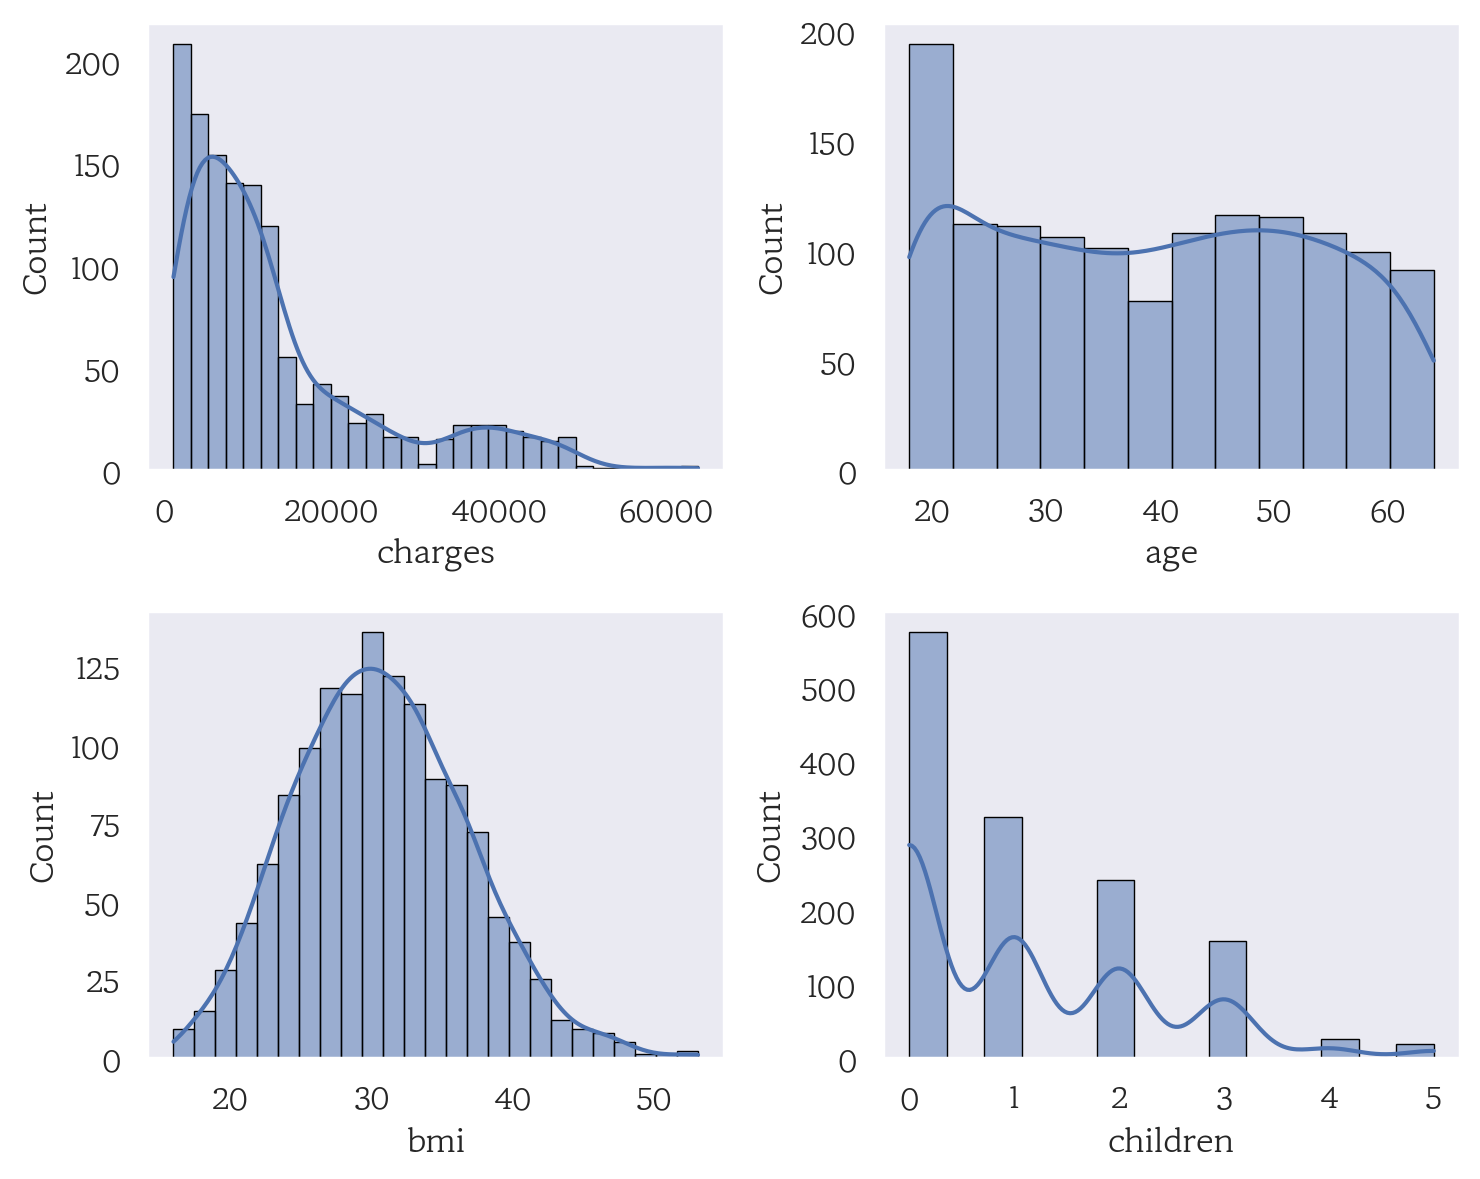

In [57]:
width_px = 1500
height_px = 1200
rows = 2
cols = 2
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# histogram 그리기
sb.histplot(data = origin, x = 'charges', kde = True, ax = ax[0][0],
            edgecolor ='#000000', linewidth = 0.5)
sb.histplot(data = origin, x = 'age', kde = True, ax = ax[0][1],
            edgecolor ='#000000', linewidth = 0.5)
sb.histplot(data = origin, x = 'bmi', kde = True, ax = ax[1][0],
            edgecolor ='#000000', linewidth = 0.5)
sb.histplot(data = origin, x = 'children', kde = True, ax = ax[1][1],
            edgecolor ='#000000', linewidth = 0.5)


# 출력
plt.tight_layout()
plt.show()
plt.close()


### 인사이트

- charges를 제외한 나머지 변수들은 분포 범위가 제한적이며 극단적으로 긴 꼬리를 보이지 않는다.

  age와 bmi는 비교적 안정적인 범위 내에서 분포하며,

  charges는 다른 변수들과 비교했을 때 분포의 비대칭성이 가장 크다.

- 이상치가 존재하는 경우, 변수에 대한 설명력이 저하되며 

  왜도가 심한 경우, 잔차의 분산이 고르지 않아 등분산성 가정 위배가 발생하며 회귀계수에 대한 신뢰성이 떨어진다.

  로그변환은 비대칭성을 완화하고, 분산을 안정화하며, 등분산성 가정 충족 여부를 보다 원활하게 만들어 준다.

- charges는 평균이 중앙값보다 크게 나타나며, 분포의 오른쪽 꼬리가 길게 늘어진 우측 왜도 분포를 보인다.

  age는 평균과 중앙값이 비교적 유사하며, 꼬리가 짧아 분포의 비대칭성이 크지 않다.

  bmi는 평균과 중앙값이 거의 일치하고, 좌우 꼬리가 비교적 대칭적인 형태를 보인다.

  children은 이산형 변수로 평균과 중앙값의 해석이 제한적이며, 값이 증가할수록 빈도가 감소하는 우측 꼬리 분포를 보인다.

- 의료비의 long-tail분포는 소수의 극단적 고액청구가 전체 결과에 영향을 미칠수 있다.

## 미션 3 "로그/비선형 변환을 고민해 보자"

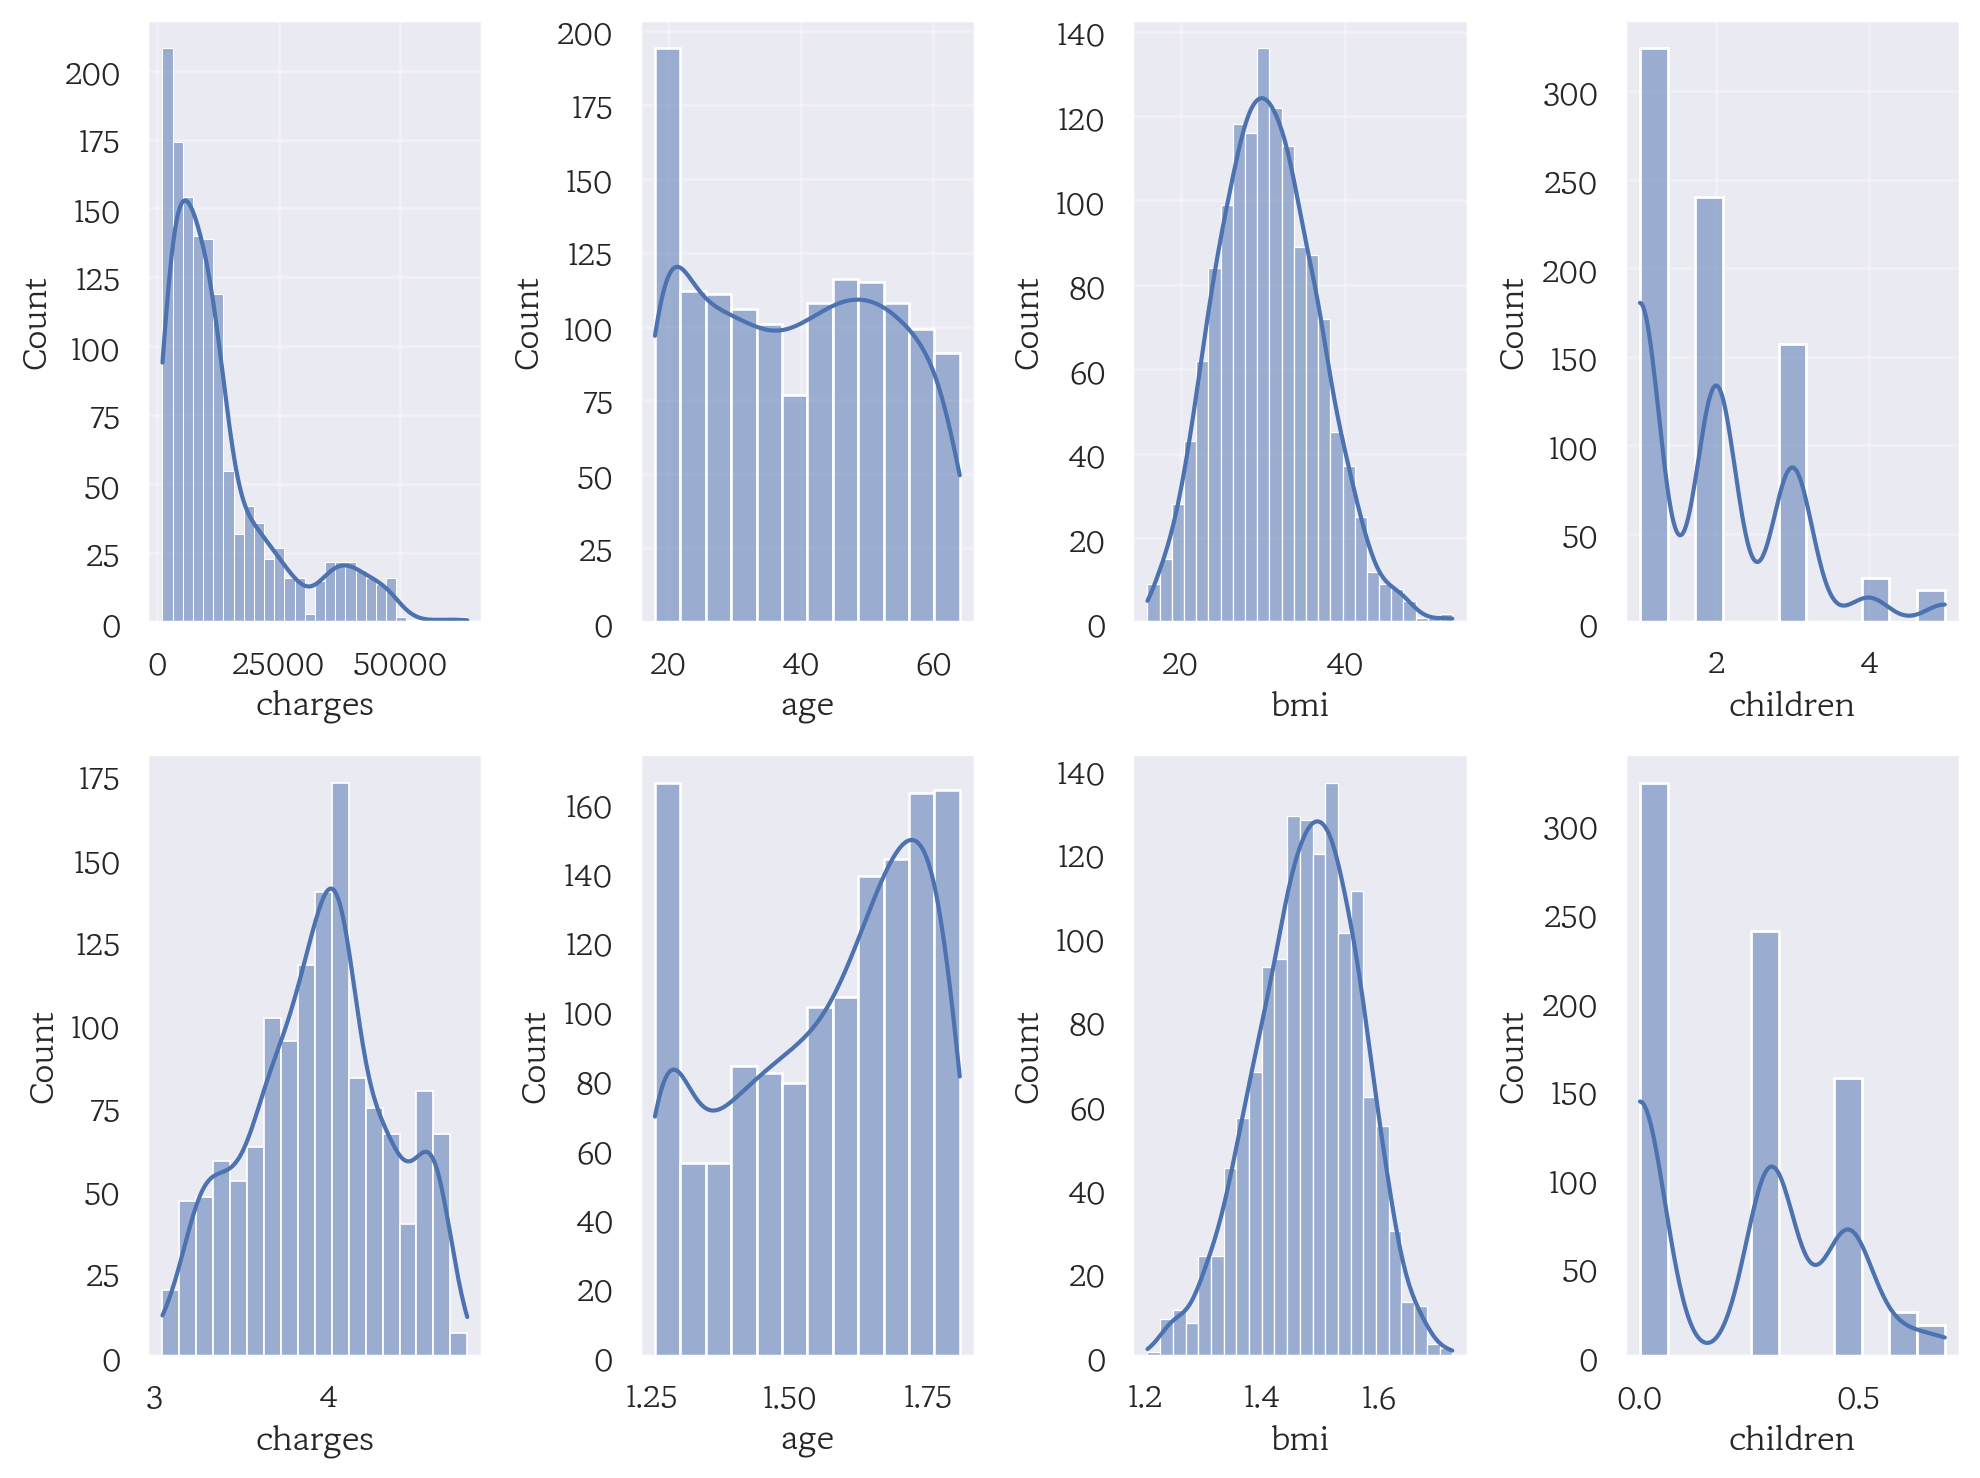

In [67]:
width_px = 2000
height_px = 1500
rows = 2
cols = 4
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

for i, col in enumerate(['charges','age','bmi','children']):
    data = origin[origin[col] > 0][col]
    log_data = np.log10(data)

    sb.histplot(data, kde = True, ax=ax[0][i])
    ax[0][i].grid(True, alpha = 0.3)

    sb.histplot(log_data, kde = True, ax=ax[1][i])
    ax[0][i].grid(True, alpha = 0.3)
# 출력
plt.tight_layout()
plt.show()
plt.close()

### 인사이트

- 장점:로그변환은 잔차의 정규성과 등분산성 충족 가능성을 높인다.

       회귀계수 추정의 안정성이 향상된다.

       선형성에 가깝게 변환이 가능하다.

- 단점: 모든 변수에 로그변환을 취할 경우, 'children' 변수처럼 오히려 더 복잡해질 수 있다.

- 어떻게 달라질까? -> 상대적(비율) 해석으로 변화한다.

- 이 변환이 없으면 어떤 함정에 빠질까? -> 소수의 long-tail 분포(극단적 고액 청구)에 의해 통계적 추론이 왜곡될 수 있다. 

## 미션 4 "성별과 거주 지역은 의료비를 결정할까?"

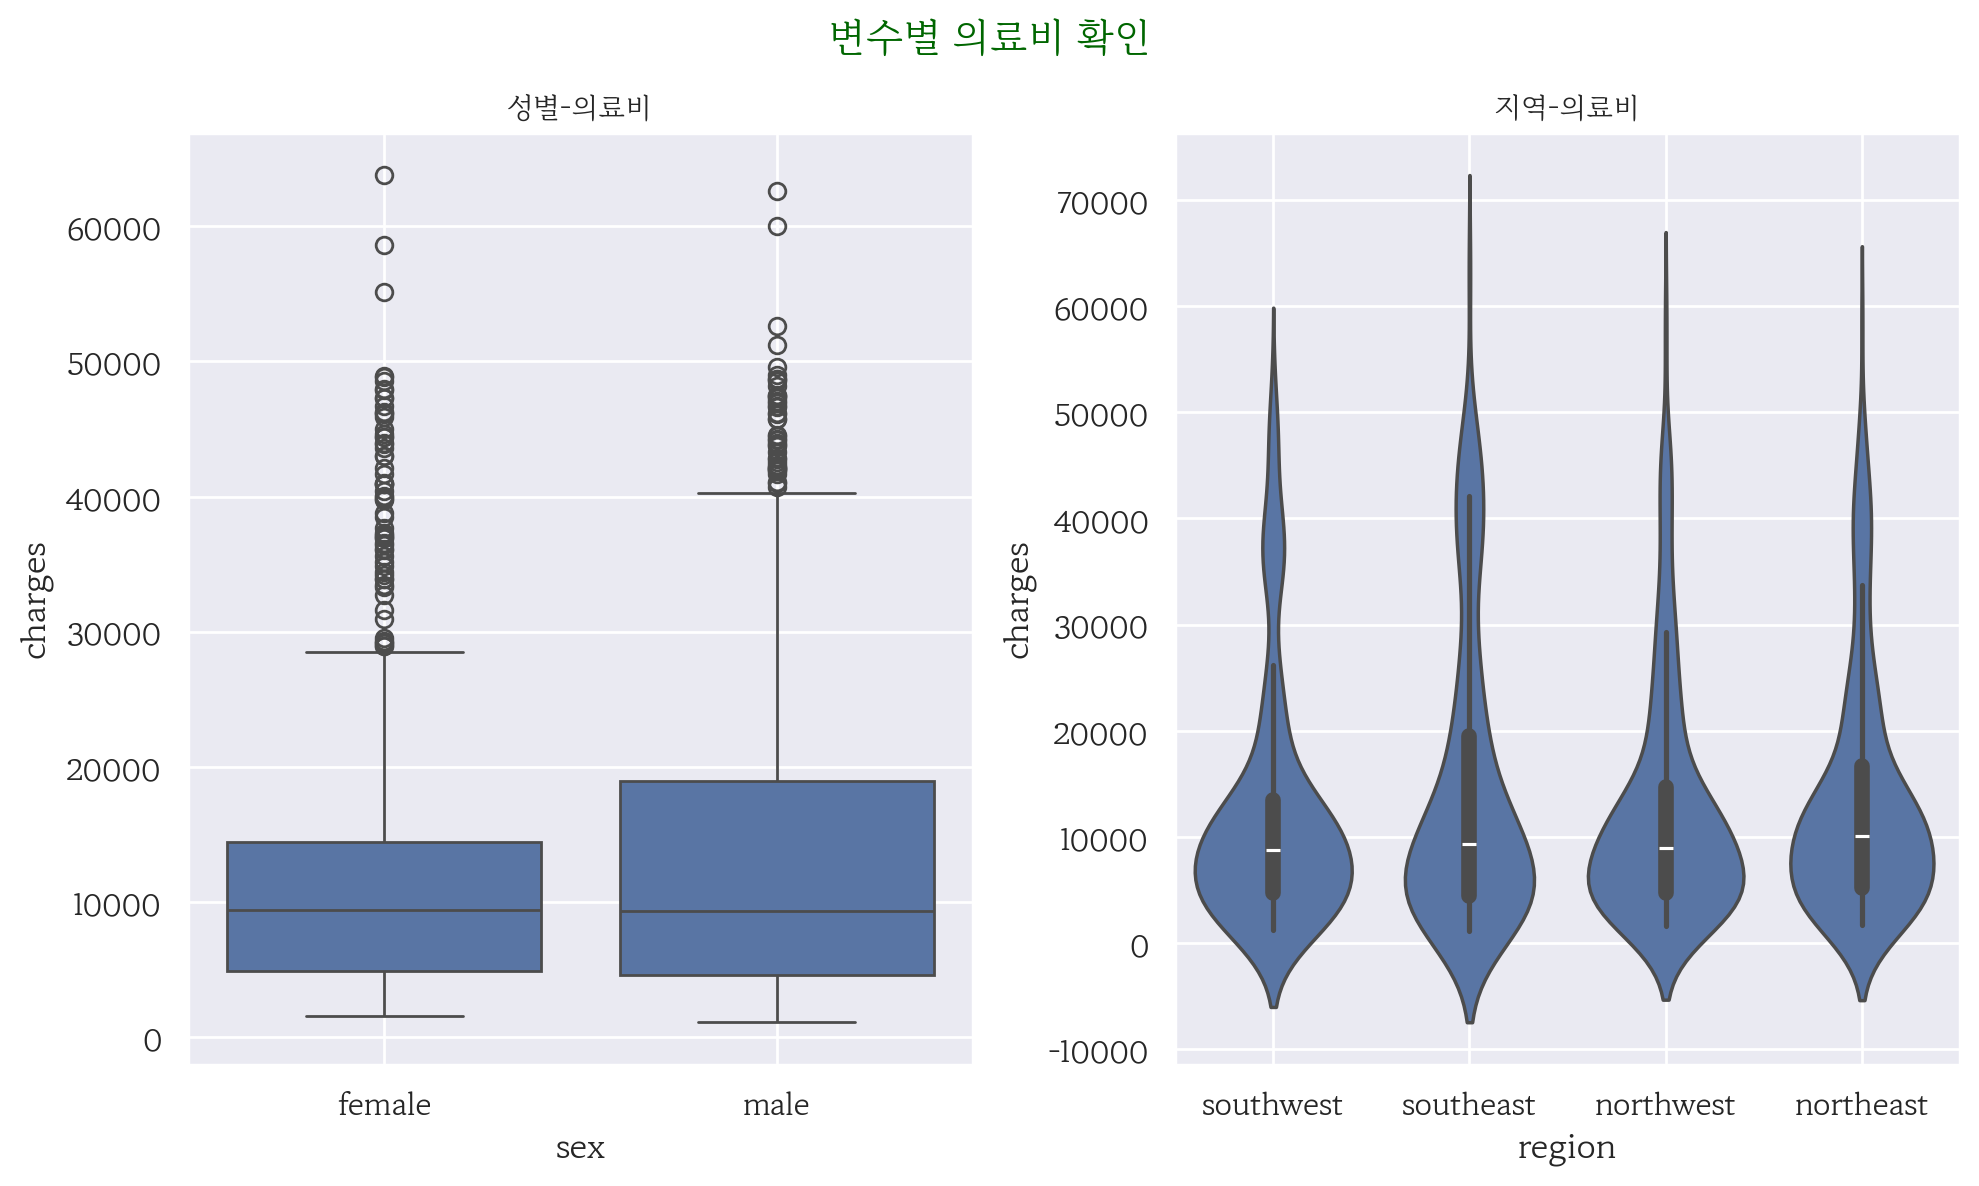

In [80]:
# plt.subplots(행,열,[figsize =(가로,세로)])
width_px = 2000
height_px = 1200
rows = 1                                                             
cols = 2                                                             
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

sb.boxplot(data=origin, x = 'sex', y = 'charges', ax=ax[0])
sb.violinplot(data=origin, x = 'region', y = 'charges', ax=ax[1])

fig.suptitle('변수별 의료비 확인', fontsize = 14, color ='#006600')

fig.subplots_adjust(wspace = 0.2, hspace = 0.2)

ax[0].set_title('성별-의료비', fontsize =10)
ax[1].set_title('지역-의료비', fontsize =10)
ax[0].grid()
ax[1].grid()


plt.tight_layout()
plt.show()
plt.close()


### 인사이트

- 어느 집단이 비싼가?(성별) 

  남성 집단에서 중앙값과 상위 사분위 범위가 여성보다 다소 높게 나타나며 고액 의료비 관측치도 더 많이 관찰된다. 

- 차이가 얼마나 뚜렷한가?

  두 집단의 분포가 크게 중첩되어 있어 성별 단독 변수만으로 의료비 차이가 뚜렷하다고 단정하기는 어렵다.

 
- 어느 집단이 비싼가?(지역)

  southeast와 northeast 지역의 중앙값이 다른 지역보다 약간 높게 위치한다.

- 차이가 얼마나 뚜렷한가?

  네 지역 모두 중앙값 위치가 유사하고 분포가 크게 겹친다.

  고액 의료비 구간에서도 지역 간 분포가 상당 부분 중첩되어, 지역 간 차이는 제한적이며 명확한 우열을 단정하기 어렵다.

- 왜 유의미한 차이가 발생하지 않을까?

  각 변수('sex', 'region')별로 약간의 차이가 있긴 하지만, 유의미한 차이는 보이지 않는다. 

  의료비 분포 차이는 미국 보험 회사 간의 경쟁, 의료 이용 패턴 등 복합적인 요소가 반영될 가능성이 있기 때문에, 

  본 데이터셋으로는 설명하기 어렵다. 